In [1]:
import sys
sys.path.append('../libs')


In [2]:
import numpy as np
import pandas as pd
import data_lib, plot_lib, decision_lib, validation_lib, transform_lib
from sklearn import cluster, mixture

np.random.seed(200)

In [3]:
# print available data summary
_ = data_lib.explore_datasets(datafolder="../../Data",verbose=True)
print(data_lib.LABELS_LIST)

----------------------------------------------------------------------------------------------
-- The following 4 groups were found
-- They contain 40 datasets
-- The first printed entity is the key to the returned dictionary
-----------------------------------
Group: ../../Data\6P-positive-dilution-series-1-labelled\droplet-level-data\RawData
po-di-se-1-A4, files: 13                po-di-se-1-B4, files: 13                po-di-se-1-C4, files: 13
po-di-se-1-D4, files: 13                po-di-se-1-A1, files: 13                po-di-se-1-B1, files: 13
po-di-se-1-C1, files: 13                po-di-se-1-D1, files: 13                
-----------------------------------
Group: ../../Data\6P-positive-dilution-series-2-labelled\droplet-level-data\RawData
po-di-se-2-A4, files: 13                po-di-se-2-B4, files: 13                po-di-se-2-C4, files: 13
po-di-se-2-D4, files: 13                po-di-se-2-A1, files: 13                po-di-se-2-B1, files: 13
po-di-se-2-C1, files: 13         

### Get samples for negative control

In [4]:

# load the necessary datasetes
df_di = data_lib.load_dataset(None, [
    "po-di-se-2-A4", "po-di-se-2-B1", "po-di-se-2-C1", "po-di-se-2-C4",
    "po-di-se-2-D1", "po-di-se-2-D4", "po-di-se-2-A1", "po-di-se-2-B4",

    "po-di-se-1-D4", "po-di-se-1-D1", "po-di-se-1-B4", "po-di-se-1-A4",
    "po-di-se-1-B1", "po-di-se-1-C4", "po-di-se-1-A1", "po-di-se-1-C1",

    "po-di-se-B8", "po-di-se-D8", "po-di-se-A8", "po-di-se-C8",
                                     ], 
                              datafolder="../../Data")


df_negative_control = data_lib.load_dataset([],[
    "po-di-se-1-D1", "po-di-se-1-D4",
    "po-di-se-2-D1", "po-di-se-2-D4",
    "po-di-se-D8",
                                                ], 
                                            datafolder="../../Data")
# Everything is positive contol
df_positive_control = df_di.iloc[:,:6]

# convert to numpy
np_di = df_di.to_numpy(copy=True)[:,:6]
np_negative_control = df_negative_control.to_numpy()

In [8]:
# fix clustering algorithm
prediction_axis = ['SARS-N2_POS','SARS-N1_POS','IBV-M_POS','RSV-N_POS','IAV-M_POS','MHV_POS']
#cluster_engine = cluster.DBSCAN(eps=700, n_jobs=4, min_samples=6, leaf_size=5)
whitening_engine = transform_lib.WhitenTransformer()
num_cluster = int(2**len(prediction_axis) * 1.6)
cluster_engine = cluster.KMeans(n_clusters=num_cluster, n_init='auto')
#cluster_engine = mixture.GaussianMixture(n_components=100)
decision = decision_lib.ClusterRelativeHierarchyMeanClassifier(
                                     negative_control=np_negative_control,
                                     cluster_algorithm=cluster_engine,
                                     whitening_transformer=whitening_engine,
                                     eps=0.6,
                                     contamination=0.004,
                                     prediction_axis=prediction_axis,
                                     )
df_decision = decision.predict(np_di)

[1 1 4 4 2 3 1 2 6 2 4 2 0 4 3 2 0 1 3 1 4 1 3 4 2 3 2 3 5 5 2 1 2 5 2 5 2
 3 2 2 3 4 3 2 3 4 2 2 2 3 1 4 5 4 5 4 3 2 3 4 3 1 2 4 6 3 4 3 3 2 1 3 4 4
 3 2 2 1 1 1 3 4 2 3 1 3 3 2 5 0 2 3 3 2 3 1 2 3 1 3 4 5 0]


## Plot the predictions

- Black = True negative prediction
- Green = True positive prediciton
- Purple = False negative
- Red = False positive
- yellow = outlier

#### Plot for all diseases predictions against ground truth

Firs plot is in the decorrelated coordinates, whereas the second is in original coordinates

Outlier rate: 0.0011127094783175342, n_outlier: 543

Total error rate: 0.0021489163102235078
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.003715     0.007828   0.000605   0.000419   0.000129 0.000197

Precision (TP / (TP + FP)): 0.9984011474118574
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999115     0.993251   0.998565   0.999522   0.999711 0.999551

Recall / TPR (TP / (TP + FN)): 0.9774526955480871
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
     0.95573      0.91399   0.994628   0.996254   0.998891 0.998182

Specificity / TNR (TN / (TN + FP)): 0.9998468513309295
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.999924     0.999424    0.99986   0.999948   0.999971 0.999957

Accuracy ((TP + TN) / (P + N)): 0.9978510836897765
 SARS-N2_POS  SARS-N1_POS  IBV-M_POS  RSV-N_POS  IAV-M_POS  MHV_POS
    0.996285     0.992172   0.999395   0.999581   0.999871 0.999803

F1 (2 * (precision 

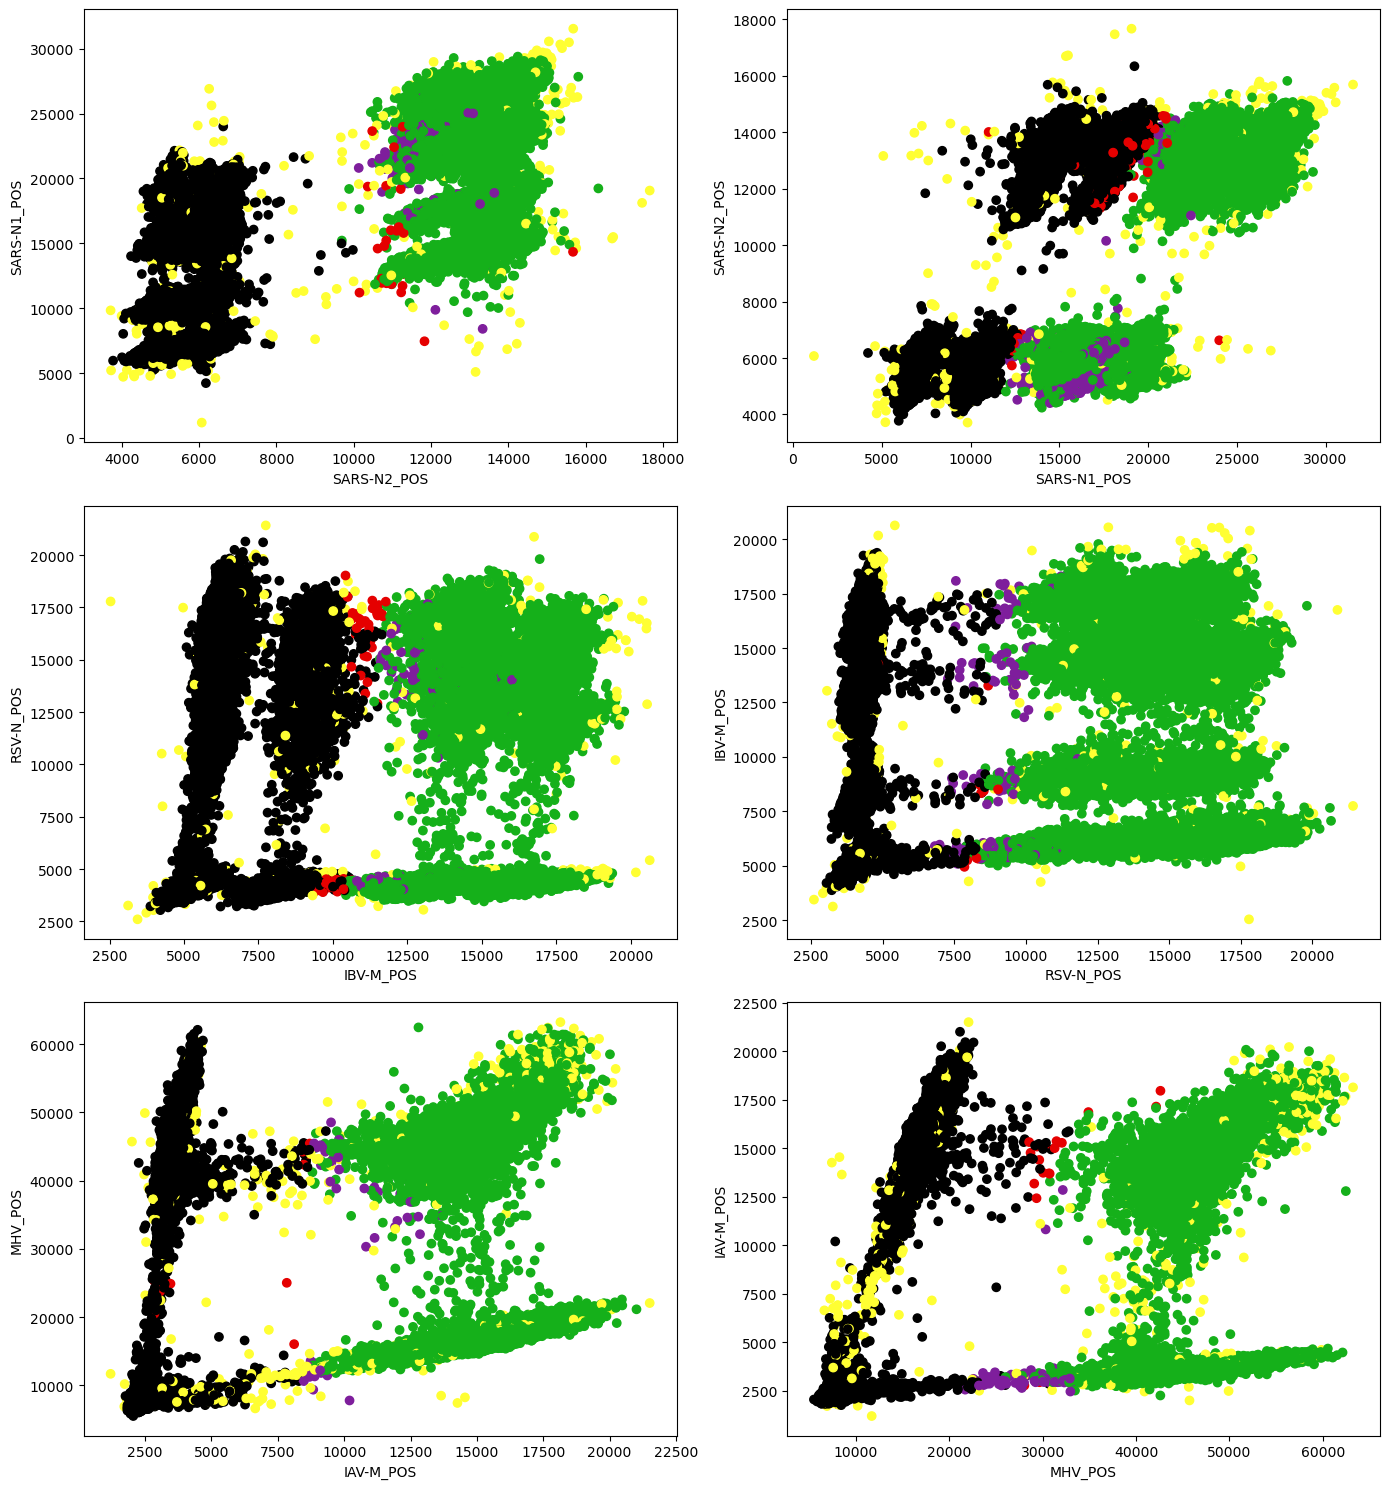

In [9]:

df_data_points = pd.DataFrame(data=decision.X, columns=prediction_axis) 
df_predictions = df_decision
df_ground_trouth = df_di
selected_pairs = [
                ('SARS-N2_POS','SARS-N1_POS'),
                ('SARS-N1_POS','SARS-N2_POS'),
                ('IBV-M_POS','RSV-N_POS'),
                ('RSV-N_POS','IBV-M_POS'),
                ('IAV-M_POS','MHV_POS'),
                ('MHV_POS','IAV-M_POS'),
                ]
mask = decision.No_neg_mask

validation_lib.validate_labels(df_di, df_decision)

plot_lib.plot_pairwise_selection(
        df_data_points,
        df_predictions,
        df_ground_trouth,
        selected_pairs,
        n_cols=2,
        mask=mask,
        )

### Error inspection

print only cluster with missclassifications

ic| cluster: -1, dim: 'IAV-M_POS', n_cluster - n_true: 236
ic| cluster: 28, dim: 'IAV-M_POS', n_cluster - n_true: 580
ic| cluster: 47, dim: 'IAV-M_POS', n_cluster - n_true: 688
ic| cluster: 60, dim: 'IAV-M_POS', n_cluster - n_true: 414
ic| cluster: 66, dim: 'IAV-M_POS', n_cluster - n_true: 502
ic| cluster: 69, dim: 'IAV-M_POS', n_cluster - n_true: 331
ic| cluster: 98, dim: 'IAV-M_POS', n_cluster - n_true: 1
ic| cluster: 99, dim: 'IAV-M_POS', n_cluster - n_true: 5
ic| cluster: -1, dim: 'MHV_POS', n_cluster - n_true: 226
ic| cluster: 98, dim: 'MHV_POS', n_cluster - n_true: 57
ic| cluster: 99, dim: 'MHV_POS', n_cluster - n_true: 28
ic| cluster: -1, dim: 'SARS-N1_POS', n_cluster - n_true: 295
ic| cluster: 1, dim: 'SARS-N1_POS', n_cluster - n_true: 492
ic| cluster: 10, dim: 'SARS-N1_POS', n_cluster - n_true: 11
ic| cluster: 12, dim: 'SARS-N1_POS', n_cluster - n_true: 7
ic| cluster: 16, dim: 'SARS-N1_POS', n_cluster - n_true: 12
ic| cluster: 20, dim: 'SARS-N1_POS', n_cluster - n_true: 728
ic

(Partially) falsely classified clusters [ -1   1   4  10  12  14  15  16  19  20  22  25  27  28  29  30  32  34
  36  37  39  47  48  50  51  57  58  59  60  62  64  65  66  67  69  70
  72  74  76  77  78  80  81  82  83  85  86  91  92  93  94  95  97  98
  99 100]


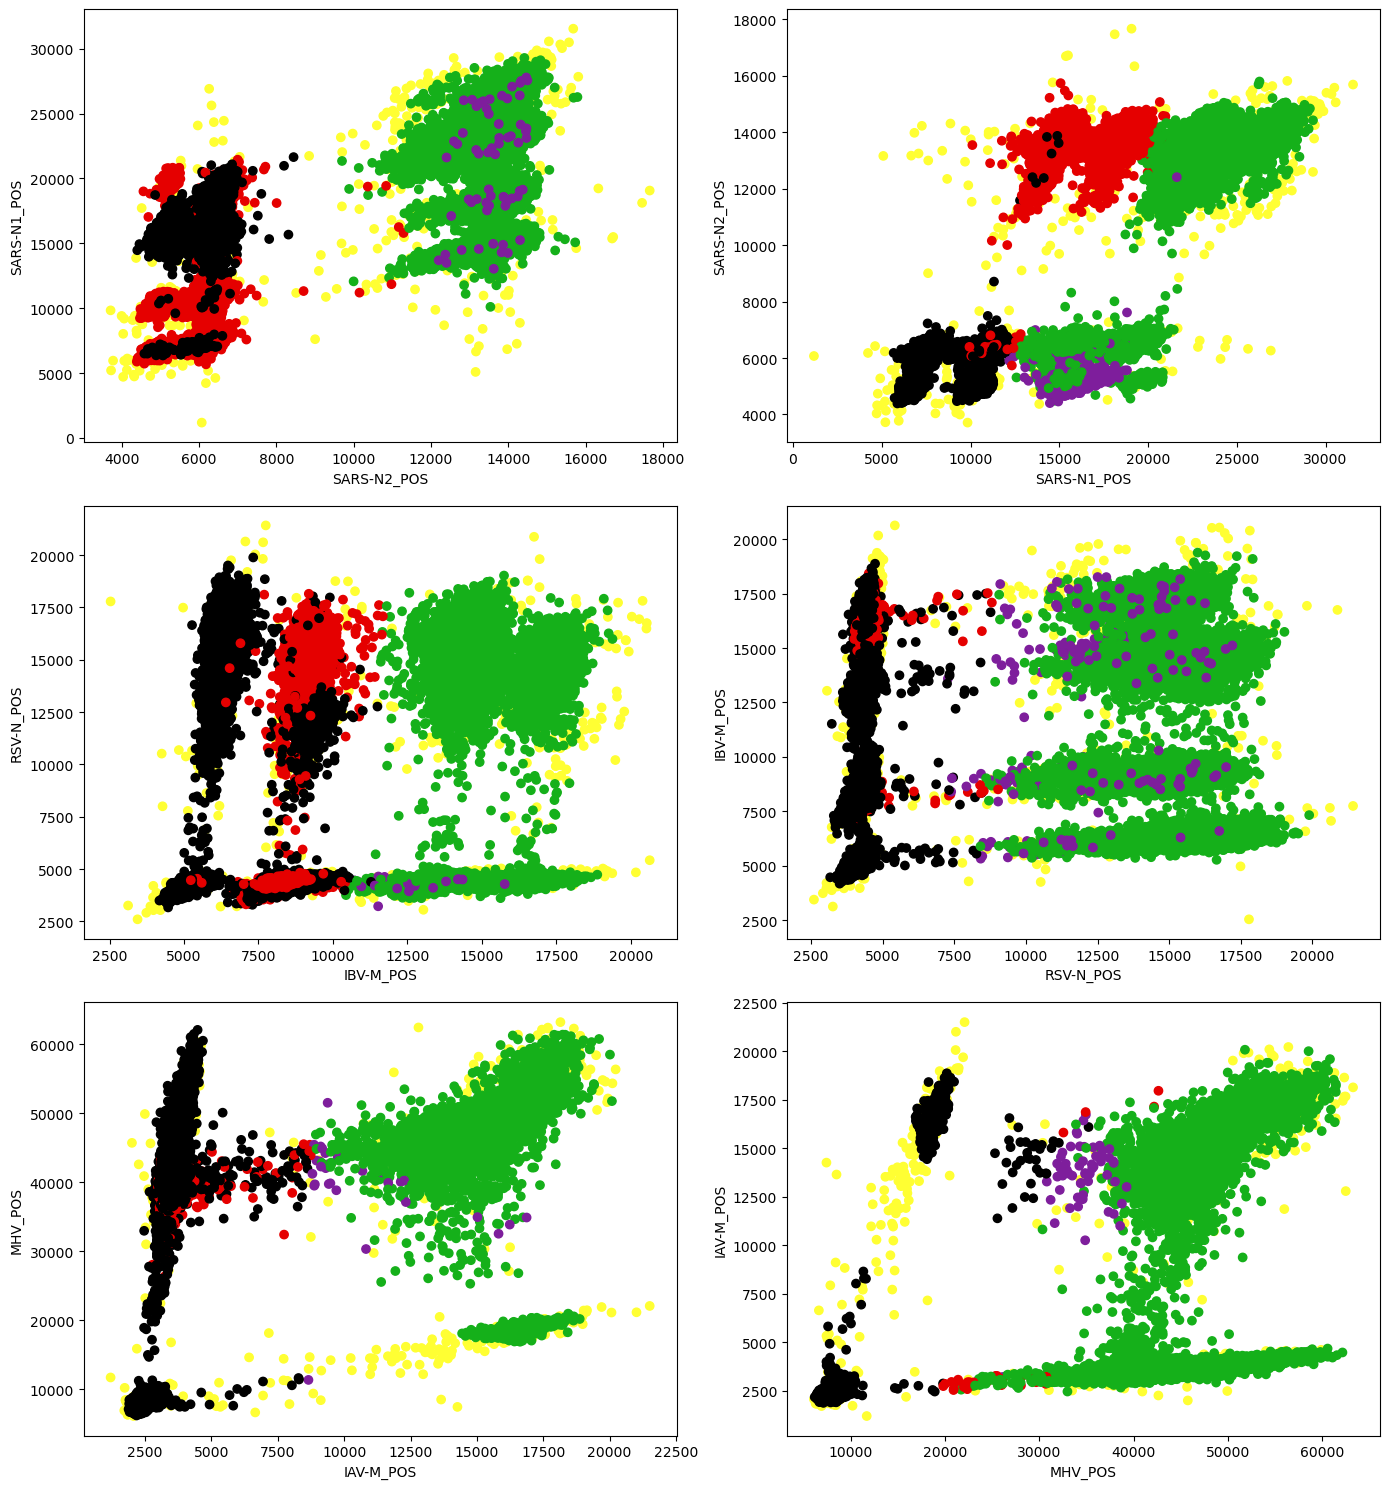

In [7]:
diseases = ["IAV-M_POS", "MHV_POS", "SARS-N1_POS", "SARS-N2_POS", "IBV-M_POS", "RSV-N_POS"]
false_clusters = validation_lib.get_false_clusters(clusters=decision.cluster_dict,
                                  df_true_labels=df_ground_trouth,
                                  df_predictions=df_predictions,
                                  disease=diseases,
                                  threshold=0.99)
df_false_data, df_false_predictions, df_false_ground_truth = validation_lib.get_false_cluster_for_plotting(df_data_points=df_data_points,
                                                                                                           df_predictions=df_predictions,
                                                                                                           df_ground_truth=df_ground_trouth,
                                                                                                           clusters=decision.cluster_dict,
                                                                                                           false_clusters=false_clusters)
print(f"(Partially) falsely classified clusters {false_clusters}")
plot_lib.plot_pairwise_selection(data_points=df_false_data, selected_pairs=selected_pairs, predictions=df_false_predictions, ground_trouth=df_false_ground_truth)